# CS 269Q: Final Project - QAOA on MIS
***
## Part 1: Using Classical Optimizer

__Note:__ Part 2: Using Grid Search is documented on another notebook.

__GOAL:__ Generate random MIS instances for simulation on the QVM and benchmark against various noise models.

## Section 1: Running on the QVM

In [1]:
from pyquil import Program, noise
from pyquil.api import WavefunctionSimulator
from pyquil.gates import H, I, RX, CNOT
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum
from scipy.optimize import minimize

import operator
import numpy as np
import matplotlib.pyplot as plt

### Noisless Implementation

From arXiv:1808.10816v1 [quant-ph], the variational wavefunctionn is prepared using the following hamiltonians:

$$H_p = \sum_{v \in V} -\Delta n_v + \sum_{(v,w) \in E} U n_v n_w$$

$$H_Q = \sum_{v \in V} \Omega \sigma_v^x + \sum_{(v,w) \in E} U n_v n_w$$

where $n_v = |1>_v<1| = \frac{I - \sigma_z}{2}$

In [2]:
def elist_from_math(string):
    string = string.replace(',','), (')
    string = string.replace(' <->',',')
    return eval('(' + string + ')')

In [3]:
def get_hamil(num_nodes, edge_list, delta, U, omega):
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

In [4]:
def mis_ansatz(betas, gammas):
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return pq

In [5]:
def mis_cost(params):
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    #init_state_prog = Program(RESET())
    #pq = init_state_prog + mis_ansatz(betas, gammas, h_cost, h_driver)
    pq = mis_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost)

In [11]:
def run_qaoa_mis(guess):
    result = minimize(mis_cost, x0 = guess, method='Nelder-Mead', options={'disp': True, 'maxiter': 100})
    wf_sim = WavefunctionSimulator()
    half = int(len(result['x'])/2)
    pq = mis_ansatz(result['x'][:half],result['x'][half:])
    wavefunction = wf_sim.wavefunction(pq)
    prob_dict = wavefunction.get_outcome_probs() 
    sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
    return sorted_dict[len(prob_dict)-1]

In [6]:
# elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
#           (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
#string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8'

string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5'
elist = elist_from_math(string)

num_nodes = 5
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

In [19]:
%%time
result = run_qaoa_mis([0.5, 0.5, 0.5, 0.5])
print(result)

('10100', 0.10241357111186623)
Wall time: 11.5 s


In [16]:
# correct = '1011010000'
# correct = '10110110'
correct = '10100'
p_vals = []
prob_vals = []
for p in range(1,11):
    params = [0.5] * 2 * p
    result = run_qaoa_mis(params)
    if (result[0] == correct):
        p_vals.append(p)
        prob_vals.append(result[1])
    else:
        print("BAD p value:", p, "with State:", result[0])

Optimization terminated successfully.
         Current function value: -0.907407
         Iterations: 51
         Function evaluations: 96
BAD p value: 1 with State: 00000
Optimization terminated successfully.
         Current function value: -1.445857
         Iterations: 75
         Function evaluations: 136
BAD p value: 5 with State: 00000
BAD p value: 6 with State: 01000
BAD p value: 7 with State: 01001
BAD p value: 9 with State: 01000
BAD p value: 10 with State: 00000


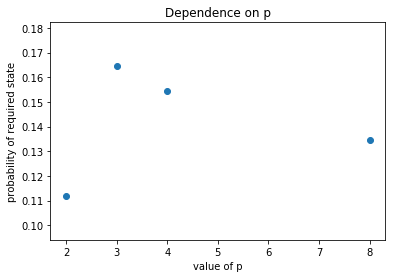

In [17]:
plt.scatter(p_vals, prob_vals) 
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of required state")
#plt.savefig("p_graph3.png")
plt.show()

In [45]:
prob_vals

[0.10241589381176748,
 0.1852167182088926,
 0.20558281325232938,
 0.22121284112690462]

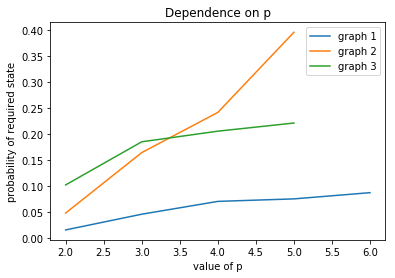

In [9]:
plt.plot([2, 3, 4, 5, 6], [0.016013513616306287, 0.04616845137756441, 0.07077191741821537, 0.07560195740556097,
 0.08751310563042292], label = 'graph 1') 
plt.plot([2, 3, 4, 5], [0.04844621167737641, 0.16448709267207717, 0.24162292345998912, 0.3955198436659367], label = 'graph 2')
plt.plot([2, 3, 4, 5], [0.10241589381176748, 0.1852167182088926, 0.20558281325232938, 0.22121284112690462], label = 'graph 3')
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of required state")
plt.legend()
#plt.savefig("p_dep.png")
plt.show()

__I can do 5 types of analyses:__
1. Let Nealder-Mead run forever and forever
2. Stop at 100 iters
3. Grid search for params
4. Grid search with width decreasing
5. Adding noise

### Implementation with Noise

In [25]:
gate = RX(1,2)
gate.qubits

[<Qubit 2>]

In [14]:
gates = [I, RX(np.pi), RX(-np.pi), RX(np.pi/2), RX(-np.pi/2), CZ, CNOT]
noise_model = noise._decoherence_noise_model(gates, T1=3e-05, T2=3e-05, gate_time_1q=5e-08, gate_time_2q=1.5e-07, ro_fidelity=0.95)

TypeError: RX() missing 2 required positional arguments: 'angle' and 'qubit'

In [22]:
def mis_ansatz(betas, gammas):
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    noise.apply_noise_model(pq, noise_model)
    return pq

In [22]:
prog = mis_ansatz([1,2],[3,4])
print(prog)

X 0
PHASE(-2.625) 0
X 0
PHASE(-2.625) 0
RZ(-6.0) 0
RZ(-6.0) 1
RZ(-3.75) 2
RZ(-6.0) 3
RZ(-3.75) 4
CNOT 0 1
RZ(2.25) 1
CNOT 0 1
CNOT 0 2
RZ(2.25) 2
CNOT 0 2
CNOT 0 3
RZ(2.25) 3
CNOT 0 3
CNOT 0 4
RZ(2.25) 4
CNOT 0 4
CNOT 1 2
RZ(2.25) 2
CNOT 1 2
CNOT 1 3
RZ(2.25) 3
CNOT 1 3
CNOT 1 4
RZ(2.25) 4
CNOT 1 4
CNOT 2 3
RZ(2.25) 3
CNOT 2 3
CNOT 3 4
RZ(2.25) 4
CNOT 3 4
H 0
RZ(1.0) 0
H 0
H 1
RZ(1.0) 1
H 1
H 2
RZ(1.0) 2
H 2
H 3
RZ(1.0) 3
H 3
H 4
RZ(1.0) 4
H 4
X 0
PHASE(-3.375) 0
X 0
PHASE(-3.375) 0
RZ(-3.0) 1
RZ(-3.0) 0
CNOT 0 1
RZ(0.75) 1
CNOT 0 1
RZ(-2.25) 2
CNOT 0 2
RZ(0.75) 2
CNOT 0 2
RZ(-3.0) 3
CNOT 0 3
RZ(0.75) 3
CNOT 0 3
RZ(-2.25) 4
CNOT 0 4
RZ(0.75) 4
CNOT 0 4
CNOT 1 2
RZ(0.75) 2
CNOT 1 2
CNOT 1 3
RZ(0.75) 3
CNOT 1 3
CNOT 1 4
RZ(0.75) 4
CNOT 1 4
CNOT 2 3
RZ(0.75) 3
CNOT 2 3
CNOT 3 4
RZ(0.75) 4
CNOT 3 4
X 0
PHASE(-3.5) 0
X 0
PHASE(-3.5) 0
RZ(-8.0) 0
RZ(-8.0) 1
RZ(-5.0) 2
RZ(-8.0) 3
RZ(-5.0) 4
CNOT 0 1
RZ(3.0) 1
CNOT 0 1
CNOT 0 2
RZ(3.0) 2
CNOT 0 2
CNOT 0 3
RZ(3.0) 3
CNOT 0 3
CNOT 0 4
RZ(3.0) 4


In [23]:
elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
         (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
h_cost, h_driver = get_hamil(10, elist, 1, 1.5, 0.5)
run_qaoa_mis([0.5,0.5,0.5,0.5])

NoisyGateUndefined: Undefined gate and params: CNOT()
Please restrict yourself to I, RX(+/-pi), RX(+/-pi/2), CZ

## Section 2: Running on the QCS

In [ ]:
from pyquil import get_qc

### Rough Work

In [10]:
string = "1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8"
string = string.replace(',','),(')
string.replace('<->',',')

'1 , 2),( 1 , 3),( 1 , 4),( 1 , 5),( 2 , 7),( 3 , 4),( 3 , 7),( 4 , 6),( 4 , 7),( 7 , 8'

In [3]:
#graph = [(0, 1), (0, 2), (0, 3)]
graph = [(1 , 4),( 1 , 7),( 1 , 8),( 1 , 9),( 1 , 10),( 2 , 5),( 2 , 6),( 2 , 8),( 3 , 4),( 3 , 5),
         ( 3 , 7),( 4 , 7),( 4 , 10),( 5 , 6),( 5 , 9),( 6 , 7),( 6 , 9),( 6 , 10),( 7 , 9),( 9 , 10)]
nodes = range(11)

#init_state_prog = Program(RESET())
delta = 1
U = 1.5
omega = 0.5
h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in graph)
h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in graph)

In [4]:
def mis_ansatz(betas, gammas):
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return pq

def mis_cost(params):
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    #program = init_state_prog + qaoa_ansatz(betas, gammas)
    program = mis_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog = program, pauli_terms = h_cost)

From arXiv:1808.10816v1 [quant-ph], the variational wavefunctionn is prepared using the following hamiltonians:

$$H_p = H_{cost} = \sum_{v \in V} -\Delta n_v + \sum_{(v,w) \in E} U n_v n_w$$

$$H_Q = H_{driver} = \sum_{v \in V} \Omega \sigma_v^x + \sum_{(v,w) \in E} U n_v n_w$$

where $n_v = |1>_v<1| = \frac{I - \sigma_z}{2}$

In [5]:
# %%time
result = minimize(mis_cost, x0=[1, 1, 1, 1, 1, 1], method='Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: -3.018811
         Iterations: 505
         Function evaluations: 798


In [6]:
result

 final_simplex: (array([[ 1.02244522,  0.67252986,  0.51393121, -0.08425901, -0.3537811 ,
         0.01441819],
       [ 1.02244652,  0.67253461,  0.51393231, -0.0842919 , -0.35381464,
         0.01438602],
       [ 1.02244778,  0.67253452,  0.51391269, -0.08419627, -0.35376288,
         0.01439416],
       [ 1.02244153,  0.67255446,  0.51392772, -0.08420493, -0.35375761,
         0.0143849 ],
       [ 1.02244771,  0.67255897,  0.51391645, -0.08422519, -0.35377353,
         0.01437625],
       [ 1.02243362,  0.67255758,  0.51392511, -0.08417244, -0.35376219,
         0.01434687],
       [ 1.02245729,  0.67253653,  0.51392716, -0.08426053, -0.35379275,
         0.0143901 ]]), array([-3.01881051, -3.01881051, -3.01881051, -3.01881051, -3.01881051,
       -3.01881051, -3.01881051]))
           fun: -3.018810509386274
       message: 'Optimization terminated successfully.'
          nfev: 798
           nit: 505
        status: 0
       success: True
             x: array([ 1.02244522,  0.

In [ ]:
print(result)

In [7]:
wf_sim = WavefunctionSimulator()
pq = mis_ansatz(result['x'][:3],result['x'][3:])
wavefunction = wf_sim.wavefunction(pq)
prob_dict = wavefunction.get_outcome_probs() 

In [8]:
sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
print(sorted_dict[len(prob_dict)-1])

('10110100001', 0.0388841106282332)


In [ ]:
# ('10110100001', 0.0388841106282332) p = 3, x0 = 1
# ('10110100001', 0.010002220425218854) p = 2, x0 = 0.5

In [ ]:
# The amplitudes are stored as a numpy array on the Wavefunction object
print(wavefunction.amplitudes)
prob_dict = wavefunction.get_outcome_probs() # extracts the probabilities of outcomes as a dict
print(prob_dict)
print(max(prob_dict.values()))

In [20]:
mis_cost([3.14, 3.14, 3.14, 3.14])

-5.0734525477436065e-06